In [1]:
# 
import sys
import time
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from IPython import display
from matplotlib import animation, cm

import ott

# SGW Library
from SGW.lib.sgw_numpy import sgw_cpu

In [2]:
# Samples spiral
def sample_spiral(
    n, min_radius, max_radius, key, min_angle=0, max_angle=10, noise=1.0
):
    radius = jnp.linspace(min_radius, max_radius, n)
    angles = jnp.linspace(min_angle, max_angle, n)
    data = []
    noise = jax.random.normal(key, (2, n)) * noise
    for i in range(n):
        x = (radius[i] + noise[0, i]) * jnp.cos(angles[i])
        y = (radius[i] + noise[1, i]) * jnp.sin(angles[i])
        data.append([x, y])
    data = jnp.array(data)
    return data


# Samples Swiss roll
def sample_swiss_roll(
    n, min_radius, max_radius, length, key, min_angle=0, max_angle=10, noise=0.1
):
    spiral = sample_spiral(
        n, min_radius, max_radius, key[0], min_angle, max_angle, noise
    )
    third_axis = jax.random.uniform(key[1], (n, 1)) * length
    swiss_roll = jnp.hstack((spiral[:, 0:1], third_axis, spiral[:, 1:]))
    return swiss_roll


# Plots spiral and Swiss roll
def plot(
    swiss_roll, spiral, colormap_angles_swiss_roll, colormap_angles_spiral
):
    fig = plt.figure(figsize=(11, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(spiral[:, 0], spiral[:, 1], c=colormap_angles_spiral)
    ax.grid()
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.view_init(7, -80)
    ax.scatter(
        swiss_roll[:, 0],
        swiss_roll[:, 1],
        swiss_roll[:, 2],
        c=colormap_angles_swiss_roll,
    )
    ax.set_adjustable("box")
    plt.show()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


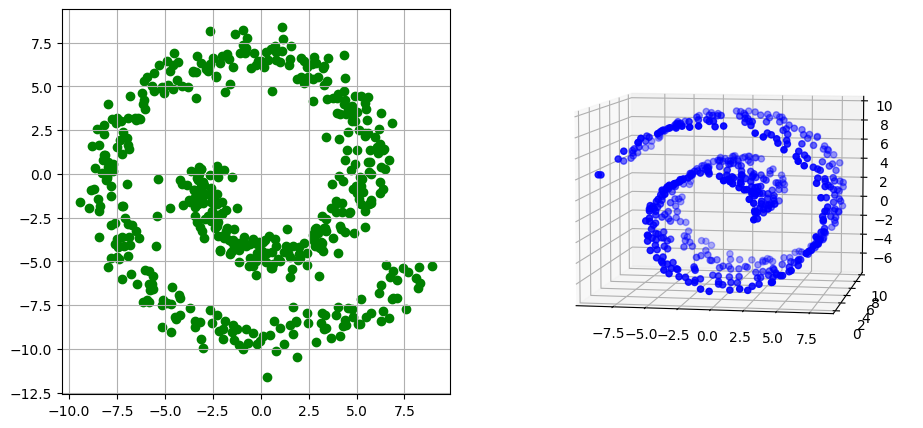

In [3]:
# Data parameters
n_spiral = 500
n_swiss_roll = 500
length = 10
min_radius = 3
max_radius = 10
noise = 0.8
min_angle = 0
max_angle = 9
angle_shift = 3
# Seed
seed = 14
key = jax.random.PRNGKey(seed)
key, *subkey = jax.random.split(key, 4)
spiral = sample_spiral(
    n_spiral,
    min_radius,
    max_radius,
    key=subkey[0],
    min_angle=min_angle + angle_shift,
    max_angle=max_angle + angle_shift,
    noise=noise,
)
swiss_roll = sample_swiss_roll(
    n_swiss_roll,
    min_radius,
    max_radius,
    key=subkey[1:],
    length=length,
    min_angle=min_angle,
    max_angle=max_angle,
)

plot(swiss_roll, spiral, "blue", "green")

In [6]:
%%time
# apply Sinkhorm based Gromov-Wasserstein
geom_xx = ott.geometry.pointcloud.PointCloud(x=spiral, y=spiral)
geom_yy = ott.geometry.pointcloud.PointCloud(x=swiss_roll, y=swiss_roll)
prob = ott.problems.quadratic.quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=100.0, max_iterations=20)
out = solver(prob)

n_outer_iterations = jnp.sum(out.costs != -1)
has_converged = bool(out.linear_convergence[n_outer_iterations - 1])
print(f"{n_outer_iterations} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularized GW cost is: {out.reg_gw_cost:.3f}")

5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 1185.040
CPU times: user 9.51 s, sys: 1.21 s, total: 10.7 s
Wall time: 9.48 s


In [7]:
%%time
print(spiral.shape, swiss_roll.shape)
for npx in [10, 20, 50]:
    gwx = sgw_cpu(spiral, swiss_roll,nproj=npx)
    print(f"Spliced GW: Number of Projections : {npx}; GW Dist : {gwx}")
    

(500, 2) (500, 3)
Spliced GW: Number of Projections : 10; GW Dist : 815.0234196700104
Spliced GW: Number of Projections : 20; GW Dist : 952.2274173851963
Spliced GW: Number of Projections : 50; GW Dist : 1016.1940748403199
CPU times: user 123 ms, sys: 11.6 ms, total: 134 ms
Wall time: 30.8 ms
